**Table of contents**<a id='toc0_'></a>    
- 1. [Illustrating the Edgeworth box given set $\mathcal{C}$](#toc1_)    
- 2. [Calculating the error in the market clearing conditions](#toc2_)      
- 3. [Market clearing price](#toc3_)    
- 4. [Price optimization](#toc4_)
- 5. [Utility optimization](#toc5_)
- 6. [Social planner optimization](#toc6_)
- 7. [Drawing of set $\mathcal{W}$](#toc7_)
- 8. [Market equilibrium](#toc8_)         
<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Imports

In [16]:
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model class

The ExchangeEconomyClass file code has been inserted into the below box.

In [17]:

from types import SimpleNamespace
import numpy as np
from scipy import optimize
class ExchangeEconomyClass:

    def __init__(self):

        par = self.par = SimpleNamespace()

        # Setting preferences references
        par.alpha = 1/3
        par.beta = 2/3

        # Determine endowments
        par.w1A = 0.8
        par.w2A = 0.3
        
        # Parameters to be valued later
        sol = self.sol = SimpleNamespace()
        sol.x1 = np.nan
        sol.x2 = np.nan
        sol.u = np.nan
        sol.p = np.nan
    
    def utility_A(self,x1A,x2A):
        '''Utility function for consumer A dependent on good 1 and 2'''
        return x1A**par.alpha*x2A**(1-self.par.alpha)
    def utility_B(self,x1B,x2B):
        return x1B**self.par.beta*x2B**(1-self.par.beta)

    
    def demand_A(self, p1):
        x1A = self.par.alpha * ((p1 * self.par.w1A + self.par.w2A) / p1)
        x2A = (1 - self.par.alpha) * (p1 * self.par.w1A + self.par.w2A)
        return x1A, x2A 
    
    def demand_B(self, p1):
        par = self.par
        x1B = self.par.beta*((p1*(1-self.par.w1A)+(1-self.par.w2A))/p1)
        x2B = (1-self.par.beta)*((p1*(1-self.par.w1A)+(1-self.par.w2A)))
        return x1B, x2B
    
    def check_market_clearing(self,p1):

        par = self.par

        x1A,x2A = self.demand_A(p1)
        x1B,x2B = self.demand_B(p1)

        eps1 = x1A-par.w1A + x1B-(1-par.w1A)
        eps2 = x2A-par.w2A + x2B-(1-par.w2A)

        return eps1,eps2
    
    def pareto(self, x1A, x2A):
        par = self.par
        pareto = []
        init_utilityA = self.utility_A(par.w1A, par.w2A)
        init_utilityB = self.utility_B(1 - par.w1A, 1 - par.w2A)
        for i, c in enumerate(x1A):
            for j, d in enumerate(x2A):
                if self.utility_A(c, d) >= init_utilityA and self.utility_B(1 - c, 1 - d) >= init_utilityB:
                    pareto.append((c, d))
        return pareto
    
    
    def solve_A(self):
  
        
        # Function for minimization 
        obj = lambda p1: -self.utility_A(1 - self.demand_B(p1)[0],1 - self.demand_B(p1)[1]) # minimize -> negative of utility
            
        # Constraints taking lowest value of 1*10^(-8)
        bounds = ((1e-8,None),)
                
        # Solver
        p10 = 1.5
        result = optimize.minimize(obj,p10,method='SLSQP',bounds=bounds)
            
        # Load
        p1opt = result.x[0]
        utilityA_opt = self.utility_A(self.demand_A(p1opt)[0],self.demand_A(p1opt)[1])
        return p1opt, utilityA_opt
    def solve_social_planner(self):
 
        
        # a. objective function (to minimize) 
        obj = lambda xA: -(self.utility_A(xA[0],xA[1]) + self.utility_B(1 - xA[0],1 - xA[1])) # minimize -> negative of utility
            
        # b. constraints and bounds
        # budget_constraint = lambda x: par.m-par.p1*x[0]-par.p2*x[1] # violated if negative
        # constraints = ({'type':'ineq','fun':budget_constraint})
        bounds = ((1e-8,1),(1e-8,1))
                
        # c. call solver
        x0 = [0.5,0.5]
        result = optimize.minimize(obj,x0,method='SLSQP',bounds=bounds)
            
        # d. save
        x1Aopt, x2Aopt = result.x
        # utilityA = self.utility_A(x1Aopt,x2Aopt)
        return x1Aopt, x2Aopt
    
    def solve_market_equilibrium(self, w1A):
        p1_eq = np.zeros(len(w1A)) # empty array to store equilibrium prices
        for i in range(len(w1A)):
            obj = lambda p1: self.demand_A(p1)[0]-w1A[i] + self.demand_B(p1)[0]-(1-w1A[i])
            res = optimize.root_scalar(obj,bracket=(1e-8,10),method='bisect')
            p1_eq[i] = res.root
        x1A_eq, x2A_eq = self.demand_A(p1_eq)
        X1B_eq, X2B_eq = self.demand_B(p1_eq)
        return x1A_eq, x2A_eq, X1B_eq, X2B_eq
    
    
      # Function that solves
    def solve(self, type="central"):
        par = self.par
        sol = self.sol

        # objective function to be minimized and constraints, depending on type chosen
        if type == "central":
            obj_fun = lambda x: -(self.utility_A(x[0],x[1])+self.utility_B((1-x[0]),(1-x[1])))       # The social planner maximises aggregate utility subject to available supply
            constraints = ({'type': 'ineq', 'fun': lambda x: x[0]-par.w1A+(1-x[0])-(1-par.w1A)})
        elif type == "mm":
            obj_fun = lambda x: -(self.utility_A(x[0],x[1]))        # A maximises their own utility, subject to the available supply and that B is not worse of than at the beginning
            constraints = ({'type': 'ineq', 'fun': lambda x: x[0]-par.w1A+(1-x[0])-(1-par.w1A)},{'type': 'ineq', 'fun': lambda x: self.utility_B(1-x[0],1-x[1])-self.utility_B(1-par.w1A,1-par.w2A)})
        elif type == 'market':                                      # The market finds the efficient allocation that makes the goods markets clear
            obj_fun = lambda x: np.sum(np.abs(self.check_market_clearing(x)))
        else:
            print('no type chosen')
            
 # call solver
        if type == 'market':        # Market maker uses different solver as constraints are not needed, while additional code implemting p1 is.
            initial_prices = [1.0]
            res = optimize.minimize(obj_fun, initial_prices, method='Nelder-Mead')
            # store results
            p1 = res.x[0]
            x1A, x2A = self.demand_A(p1)
            x1B, x2B = self.demand_B(p1)
            sol.p = p1
            sol.x1 = x1A
            sol.x2 = x2A
            sol.u = self.utility_A(x1A, x2A) + self.utility_B(x1B, x2B)
            #print solution
            print(f'x1A = {sol.x1:.3f} x2A = {sol.x2:.3f}, U_{type} = {sol.u:.3f}, u_A = {self.utility_A(sol.x1,sol.x2):.3f}, u_B = {self.utility_B(1-sol.x1,1-sol.x2):.3f}, p = {sol.p:.3f}')
        else:       # Both social planner and market maker optimizes utility under constraints
            initial_guess = [par.w1A,par.w2A]
            res = optimize.minimize(obj_fun,initial_guess,method='SLSQP',bounds=bounds,constraints=constraints)
            # save and print solution
            sol.x1 = res.x[0]
            sol.x2 = res.x[1]
            sol.u = -obj_fun((res.x[0],res.x[1]))
            print(f'x1A = {sol.x1:.3f} x2A = {sol.x2:.3f}, U_{type} = {sol.u:.3f}, u_A = {self.utility_A(sol.x1,sol.x2):.3f}, u_B = {self.utility_B(1-sol.x1,1-sol.x2):.3f}')

### 2.1. <a id='toc2_1_'></a>[Basic Edgeworth box](#toc0_)

In [18]:
model = ExchangeEconomyClass()

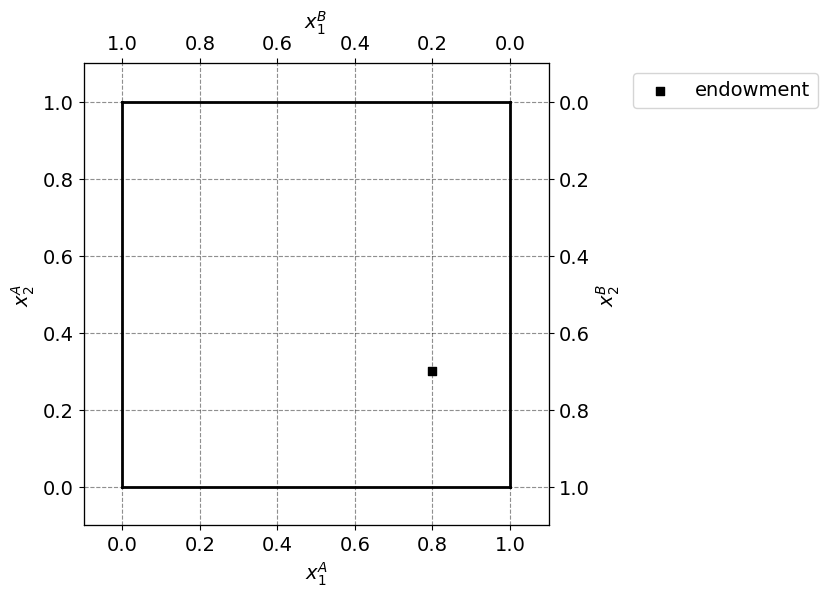

In [19]:
model = ExchangeEconomyClass()
par = model.par
# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='upper right',bbox_to_anchor=(1.6,1.0));

## 1. <a id='toc1_'></a>[Illustrating the Edgeworth box given set $\mathcal{C}$](#toc1_)

We use set $\mathcal{C}$ to illustrate the Edgeworth box, depicting the solutions on the contract curve. The pareto optimal allocations in relation to the initial endowments are computed. 

Indifference curves for each player are drawn and are convex. representing combinations of the two goods that provide the same level of utility to the given player.

Any movement from an initial point to a closer point on the contract curve would represent a Pareto improvement, leaving atleast one player better off and no one other player worse off. Thus, agents should trade within any point on the contract curve that lies withnin $\mathcal{C}$. 

namespace(alpha=0.3333333333333333, beta=0.6666666666666666, w1A=0.8, w2A=0.3)


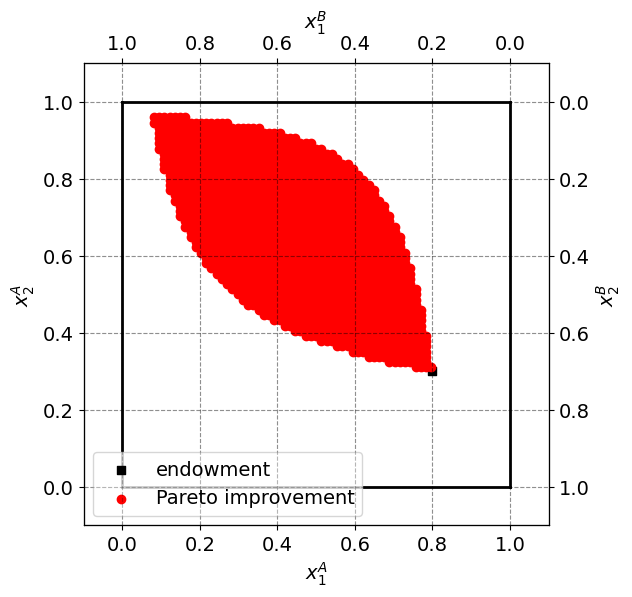

In [20]:

print(par)
N = 75 # number of points in grid for consumption
x1A, x2A = np.linspace(0,1,N), np.linspace(0,1,N)
pareto = model.pareto(x1A,x2A)

import matplotlib.pyplot as plt
# Extract the x and y coordinates from the pareto_improve list
x_coords = [pair[0] for pair in pareto]
y_coords = [pair[1] for pair in pareto]


# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(par.w1A,par.w2A,marker='s',color='black',label='endowment')
ax_A.scatter(x_coords, y_coords, label='Pareto improvement', color='red')

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True,loc='lower left');


## 2. <a id='toc2_'></a>[Calculating the error in the market clearing conditions](#toc2_)

We find possible errors in the market clearing condition by looping over possible values in $p_{1}$ for $p_{1}\in\mathcal{P_1}$ The market clearing condition is illustrated.

In [21]:
# Question 2 
p1 = []
for i in range(N+1):
    p1.append(0.5 + 2*i/N)

#initializing error term
error = []
for i in p1:
    error.append(model.check_market_clearing(i))
    
print(error[0:5])


[(0.533333333333333, -0.2666666666666666), (0.47594936708860747, -0.25066666666666654), (0.42409638554216866, -0.23466666666666652), (0.3770114942528735, -0.2186666666666665), (0.334065934065934, -0.2026666666666665)]


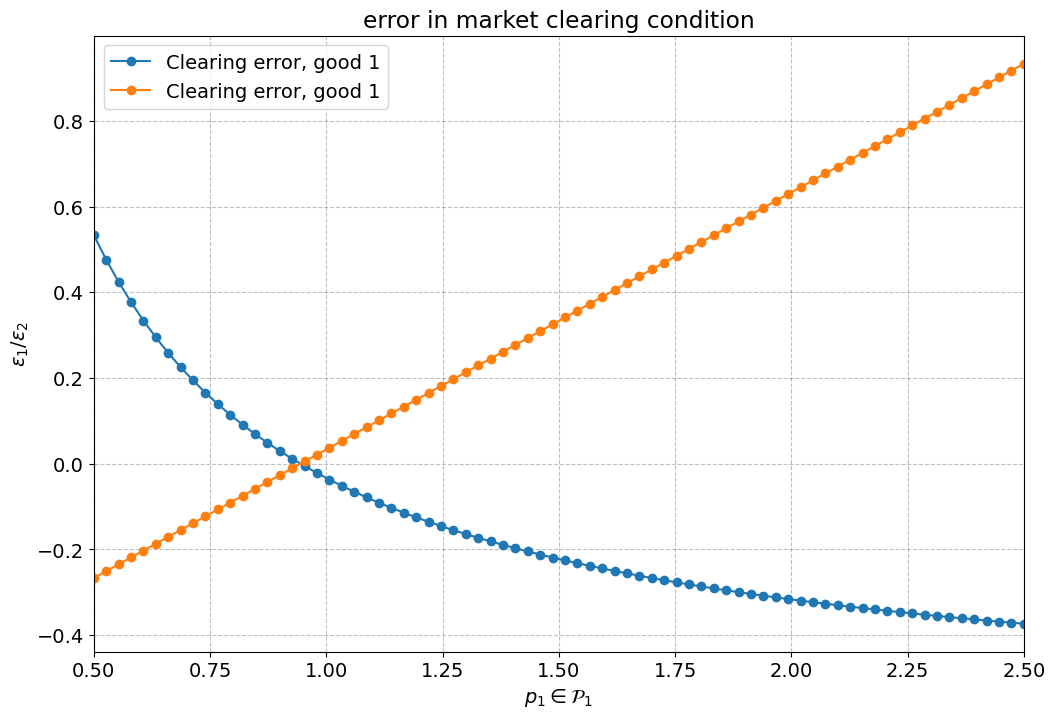

In [22]:
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(1,1,1)
ax.set_title('error in market clearing condition')
ax.plot(p1,error,'-o',label='Clearing error, good 1')

ax.set_xlabel('$p_1 \in \mathcal{P}_1$')
ax.set_ylabel('$\epsilon_1/\epsilon_2$')
ax.set_xlim([0.5, 2.5])
ax.legend(frameon=True)

By observing the above graph, the equilibrium price is identified at the intersecting graphs. This gives the equilibrium price as approximately 0.9. In this this point the error in the market clearing is 0. By applying Walras' law, this would mean the clearing of one market also clears the other.

## 3. <a id='toc3_'></a>[Market clearing price](#toc3_)

The market clearing price is given as the price at which the demand for a good equates the price. This means the clearing price is the choice of p1 that will minimize errors calculated in Question 2. The market clearing price is observed as being close to 1, but a more precisely price is now calculated. Walras' law is applied, and both markets will clear. Furthermore this means we only need to check for one of the computed errors.

In [23]:
# Solving the model using Walras's law + scipy's root_scalar function
model.solve(type='market')

# Saving the following solutions to be used for a plot later in the assignment
x1A_best_market=model.sol.x1
x2A_best_market=model.sol.x2
U_market = model.sol.u

x1A = 0.373 x2A = 0.704, U_market = 1.058, u_A = 0.569, u_B = 0.489, p = 0.944


## 4. <a id='toc4_'></a>[Price optimization](#toc4_)

## 4a. <a id='toc4_'></a>[Finding allocation if only prices in p1 can be chosen](#toc4_)


Consumer A chooses p1 from $p_{1}$ for $\mathcal{P_1}$ that will maximize her utility. The maximization of the utility is found by looping over all possible $p_{1}$ by taking into account consumer B's consumption bundle at the same given $p_{1}$.

In [24]:
utility_1 = -np.inf
price_1 = None

# Looping over p1 
for i in p1:
# Ensuring that 1-demand_B is greater than 0, so we dont end up with 0 utility for consumer A
    if 1-model.demand_B(i)[0] > 0 and 1-model.demand_B(i)[1]>0:

        # Compute the utility for the good left over for A
        utilitymax_A = model.utility_A(1-model.demand_B(i)[0], 1-model.demand_B(i)[1])
        # Renew utility_1 if utilitymax_A is greater
        if utilitymax_A > utility_1:
            utility_1 = utilitymax_A
            price_1 = i

index = np.nanargmax(utilitymax_A)
print(f'Consumer A will choose p1 = {price_1:.2f} to maximize its own utility, which is {utilitymax_A:.2f}')
print(f'The allocation is given as: x1A = {model.demand_A(price_1)[0]:.2f} and x2A = {model.demand_A(price_1)[1]:.2f}')


Consumer A will choose p1 = 1.89 to maximize its own utility, which is 0.63
The allocation is given as: x1A = 0.32 and x2A = 1.21


## 4b. <a id='toc4_'></a>[Finding allocation if any positive price can be chosen](#toc4_)

We utilize the same method seen in 4.b for $p_{1}>0$ by looping over $p_{1}$ in the given numpy range: 0 to 100. 

In [25]:
utility_2= -np.inf
anyprice_1 = None
# Loop over any price between 0 and 100
for i in np.arange(0.00001,100,1e-3):

    # Be sure that the good left over for A is of positive utility since negative good quantities will correspond to a utility value in complex numbers
    if 1-model.demand_B(i)[0] > 0 and 1-model.demand_B(i)[1]>0:

        # Compute the utility for the good left over for A
        utilitymax_A = model.utility_A(1-model.demand_B(i)[0], 1-model.demand_B(i)[1])
        
        # Update ua_best if ua is of higher value
        if utilitymax_A > utility_2:
            utility_2 = utilitymax_A
            anyprice_1 = i

print(f'If A can choose any p1>0, A chooses the price p1 = {anyprice_1:.2f} to maximize her own utility, which is then {utility_2:.2f}')
print(f'The allocation is then: x1B = {model.demand_B(anyprice_1)[0]:.2f} and x2B = {model.demand_B(anyprice_1)[1]:.2f}')
print(f'For consumer A it is: x1A = {1-model.demand_B(anyprice_1)[0]:.2f} and x2A = {1-model.demand_B(anyprice_1)[1]:.2f}')

#Why is the price almost the same as when we had to choose from the price vector? In this case we expect a lower price, when the consumer 
# can choose any price p>0 such as 0.2

If A can choose any p1>0, A chooses the price p1 = 1.90 to maximize her own utility, which is then 0.63
The allocation is then: x1B = 0.38 and x2B = 0.36
For consumer A it is: x1A = 0.62 and x2A = 0.64


## 5. <a id='toc5_'></a>[Utility optimization](#toc5_)

In question 5 we assume that A chooses B’s consumption, but such that B is not worse of than in the initial endowment. This makes A the market maker, from which A will maximize the its utility.

## 5a. <a id='toc5_'></a>[Allocation in restricted choice set](#toc5_)

A maximizes its utility while choosing the given bundle: $(x_1^A, x_2^A)$.

In [26]:
from scipy.optimize import minimize
# Assuming the list of tuples is stored in the variable 'pareto_improve'
x1A_c, x2A_c = zip(*pareto)
x1A_c, x2A_c = np.array(x1A_c).flatten(), np.array(x2A_c).flatten() # Flattening the list of tuples

utilityA_c = model.utility_A(x1A_c,x2A_c)
# print(utilityA_c)

# # Finding the maximum utility and the corresponding index (Using nanmax and nanargmax to handle NaN values)
utilityA_max_c = np.max(utilityA_c)
index_c = np.argmax(utilityA_c)

print(f'UtilityA_max_c = {utilityA_max_c:.4f}')
print(f'The allocation is for agent A: x1 = {1-x1A_c[index]:.4f}, x2 = {1-x2A_c[index]:.4f}')

UtilityA_max_c = 0.7416
The allocation is for agent A: x1 = 0.9189, x2 = 0.0541


## 5b. <a id='toc5_'></a>[Allocation without further restrictions](#toc5_)

When there are no restrictions imposed, A maximizes its utility under the given constriction s.t. Possible allocations are now infinitely large between the interval 0 to 1. N is set to 2000.

In [27]:
# Agent A optimizes utility under no further restrictions
# This is an almost identical problem, the only change, is x1A, x2A exist on the real axis in [0:1]
# Thus if N was sufficiently large in 5.1, the same solution should appear, if not, the opposite.

# Using brute force again

# Setting high N, simulating large set of numbers in [0:1]
N = 2000

# Set initial conditions
x1possible = np.linspace(0,1,N)
x2possible = np.linspace(0,1,N)
uAmax = -np.inf
x1_best = -np.inf
x2_best = -np.inf

# Just checking utility of B from initial endowments. 
print(f'$u^B(w1B,w2B)$ = {model.utility_B(1-par.w1A, 1-par.w2A):.3f}')

# similar loop as 5.a 
for x1A in x1possible:
    for x2A in x2possible:
        uAnew = model.utility_A(x1A,x2A)
        if model.utility_A(x1A,x2A) > uAmax and model.utility_B(1-x1A,1-x2A) >= model.utility_B(1-par.w1A,1-par.w2A):
            uAmax = uAnew
            x1_best = x1A 
            x2_best = x2A

print(f'Utility A max = {uAmax:.3f}: (x1A,x2A) = ({x1_best:.3f},{x2_best:.3f})')
print(f'Utility B max = {model.utility_B(1-x1_best,1-x2_best):.3f}: (x1B,x2B) = ({1-x1_best:.3f},{1-x2_best:.3f})')

$u^B(w1B,w2B)$ = 0.304
Utility A max = 0.743: (x1A,x2A) = (0.578,0.843)
Utility B max = 0.304: (x1B,x2B) = (0.422,0.157)


## 6. <a id='toc6_'></a>[Social planner optimization](#toc6_)

We assumme A’s and B’s consumption are chosen by a utilitarian social planner to maximize
aggregate utility

## 6a. <a id='toc6_'></a>[Finding the allocation](#toc6_)


In [28]:
x1A_social, x2A_social= model.solve_social_planner()
print(f'The allocation is: x1 = {x1A_social:.3f}, x2 = {x2A_social:.3f}')
print(f'The utility is {model.utility_A(x1A_social,x2A_social):.3f}')

The allocation is: x1 = 0.333, x2 = 0.667
The utility is 0.529


## 6b. <a id='toc6_'></a>[Illustration ](#toc6_)

Allocations are plotted and illustrated in the Edgeworth box

NameError: name 'x1best' is not defined

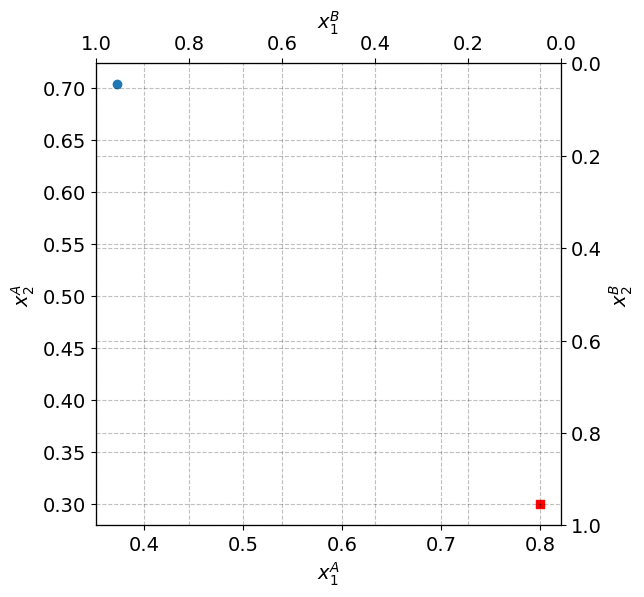

In [29]:
# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(model.par.w1A,model.par.w2A,marker='s',color='red',label='endowment')
ax_A.scatter(x1A_best_market,x2A_best_market, label=f'market, U={U_market:.4f}')
#ax_A.scatter(x1best,x2best, label=f'market maker, U={uAmax+model.utility_B(1-x1best,1-x2best):.4f}')
ax_A.scatter(x1_best,x2_best, label=f'market maker, U={uAmax+model.utility_B(1-x1best,1-x2best):.4f}')
#ax_A.scatter(model.sol.x1,model.sol.x2, label=f'social planner, U={model.sol.u:.4f}')
#ax_A.scatter(x1_possible,x2_possible, alpha=0.2, marker='x', label='pareto improvements')

x_coords, y_coords

# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])    
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.6,1.0));

Elaborate on 6)

## 7. <a id='toc7_'></a>[Drawing of set $\mathcal{W}$](#toc7_)

A set W with 50 elements are drawn. The illustration is made up of a data type that is of random endowment and drawn from uniform distribution.

In [ ]:
# Set seed for reproduceability 
np.random.seed(1)

# Generate vectors from random draws
w1A = np.random.uniform(low=0,high=1,size=50)
w2A = np.random.uniform(low=0,high=1,size=50)

# Create figure
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_D = fig.add_subplot(1, 1, 1)

ax_D.set_xlabel("$\omega_1^A$")
ax_D.set_ylabel("$\omega_2^A$")
ax_D.set_title("Random endowments, drawn from uniform distribution")

ax_D.scatter(w1A, w2A, label = "endowment pairs", color="red", marker=".")
ax_D.legend()

## 8. <a id='toc6_'></a>[Market equilibrium](#toc8_)

We find the market equilibrium allocation for each bundle. The equilibrium is plotted in the Edgeworth box.

In [30]:
equlibriums = []

for i in range(len(w1A)):
    w1A_val = w1A[i]
    w2A_val = w2A[i]
    print(f'Iteration {i+1}: w1A = {w1A_val:.3f}, w2A = {w2A_val:.3f}')
    model.par.w1A = w1A_val
    model.par.w2A = w2A_val
    model.solve(type='market')
    
    equlibriums.append((model.sol.x1, model.sol.x2))
    
    print(f'Iteration {i+1}: w1A = {w1A_val:.3f}, w2A = {w2A_val:.3f}')

# Unpack the equilibrium results
x1A_w, x2A_w = zip(*equlibriums)

# Reset model parameters to orignial:
model.par.w1A = 0.8
model.par.w2A = 0.3

NameError: name 'w1A' is not defined

NameError: name 'w1A' is not defined

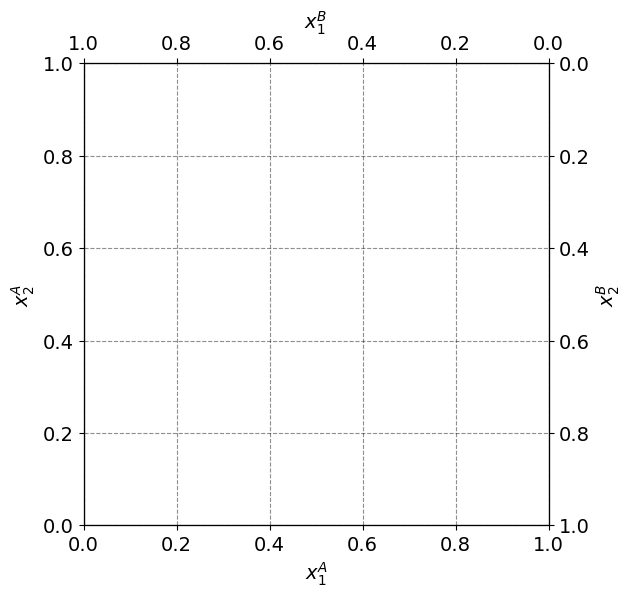

In [31]:
# a. total endowment
w1bar = 1.0
w2bar = 1.0

# b. figure set up
fig = plt.figure(frameon=False,figsize=(6,6), dpi=100)
ax_A = fig.add_subplot(1, 1, 1)

ax_A.set_xlabel("$x_1^A$")
ax_A.set_ylabel("$x_2^A$")

temp = ax_A.twinx()
temp.set_ylabel("$x_2^B$")
ax_B = temp.twiny()
ax_B.set_xlabel("$x_1^B$")
ax_B.invert_xaxis()
ax_B.invert_yaxis()

# A
ax_A.scatter(w1A,w2A,marker='.',color='red',label='Endowments')
ax_A.scatter(x1A_w,x2A_w, marker='D', s=10, label=f'Equilibriums')


# limits
ax_A.plot([0,w1bar],[0,0],lw=2,color='black')
ax_A.plot([0,w1bar],[w2bar,w2bar],lw=2,color='black')
ax_A.plot([0,0],[0,w2bar],lw=2,color='black')
ax_A.plot([w1bar,w1bar],[0,w2bar],lw=2,color='black')

ax_A.set_xlim([-0.1, w1bar + 0.1])
ax_A.set_ylim([-0.1, w2bar + 0.1])
ax_B.set_xlim([w1bar + 0.1, -0.1])
ax_B.set_ylim([w2bar + 0.1, -0.1])

ax_A.legend(frameon=True, loc='lower right', bbox_to_anchor=(1.6,1.0));

The Walras-equilibria is observed in the Edgeworth Box, displaying endowments and equilibria. It takes the shape a curve which corresponds to a contract curve which has within it the inner solutions and allocations after trade. Furthermore, in this allocation both players are both players are well off.